# Community Housing survey Project (CHP) PCA
This notebook is designed to run a categorical principle component analysis (catPCA) for the 2020 PhD-Community Initiative Housing Survey dataset

Coded by Josh Moskowitz in February 2020

---


Import the relevant libraries and other setup

In [587]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup
%matplotlib inline
pd.set_option('display.max_columns', None)

Import survey data

In [588]:
#survey = pd.read_excel('F:/Users/Josh/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
survey = pd.read_excel('C:/Users/Josh/Desktop/Dropbox/PhD-CI/KCH_01312020.xlsx',index_col=None,header=0)
questions = survey.iloc[0][:] # grab question wording and store for later

## Cleanup survey data

Remove unecessary rows and cols

In [589]:
survey.drop(index=[0,1],inplace=True) # remove first 2 rows
# Remove any irrelevant or personally idenitifying columns
survey.drop(labels=['Status','IPAddress','RecipientLastName','RecipientFirstName','RecipientEmail',
                    'ExternalReference','LocationLatitude','LocationLongitude','DistributionChannel',
                    'UserLanguage','info','consent','StartDate','EndDate','Duration (in seconds)',
                    'Progress','Finished','RecordedDate','ResponseId','num_applied_explain_2_TEXT',
                    'num_applied_explain_3_TEXT','current_living_arr_6_TEXT','why_move_7_TEXT',
                    'fam_status_5_TEXT','can_residency_3_TEXT','why_move','num_applied',
                    'num_applied_explain','private_housing','subsidy',
                   ],axis=1,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

Remove Whitespace and weird characters

In [590]:
def cleanDataFrame(obj):
    "Return a modified string"
    if isinstance(obj, str): # if object is a string
        return obj.replace("â€™", "'").strip() # fix apostrophes and remove trailing whitespace
    else:
        return obj

survey = survey.applymap(cleanDataFrame)

Function that will strip commas and split string when a person gave multiple responses

In [591]:
def cleanAndSplit(string):
    "Return a list of strings split by comma"
    
    # remove commas from one of the possible survey responses
    # "I need to be closer to work, childcare, or social/health support services"
    if "I need to be closer to work" in string:
        idx1 = string.find("childcare") - 2
        idx2 = string.find(" or ") - 1
        cleanString = string[:idx1] + string[idx1:idx2].replace(',','') + string[idx2+1:]
    else:
        cleanString = string

    return cleanString.split(',')

Function that will recode the employment column to only include one employment type

In [592]:
def recodeEmploy(row):
    "Return a Pandas row object with modified employment data"
    
    if isinstance(row.employment,str):
        listStatus = cleanAndSplit(row.employment)
        # we don't care if students are employed or not
        if 'Student' in listStatus:
            row.employment = 'Student'
        # we don't care if retirees are employed or not
        elif 'Retired' in listStatus:
            row.employment = 'Retired'
        else:
            row.employment = listStatus[0]
    return row
survey = survey.apply(recodeEmploy,axis='columns')

In [593]:
list(survey.columns) # check col names

['current_living_arr',
 'employment',
 'income_stable',
 'utilities',
 'debt',
 'mental_health',
 'substance_use',
 'gender',
 'age',
 'fam_status',
 'first_nation',
 'vis_minority',
 'can_residency']

# Prepare data for PCA
---
### Notes
Try using CountVectorizer() to encode 'why_move' column

In [594]:
# imports
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [595]:
# Select columns
oeCols = ['income_stable','utilities','mental_health','substance_use']
ohCols = [col for col in survey.drop(labels=leCols,axis=1).columns] # all other cols

In [596]:
# going to be used for ordinal encoder categories param
orders = [['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable'],
          ['Always','Frequently','Sometimes','Occasionally','Never'],
          ['Prefer not to answer','A great deal','A lot','A moderate amount',
           'A little','Not at all'],
          ['Prefer not to answer','A great deal','A lot','A moderate amount',
           'A little','Not at all']]

In [597]:
survey.isna().sum() # cols with NaNs

current_living_arr    1
employment            1
income_stable         1
utilities             3
debt                  1
mental_health         1
substance_use         1
gender                1
age                   1
fam_status            1
first_nation          1
vis_minority          1
can_residency         1
dtype: int64

In [598]:
# Find where common empty rows are and drop from table
idx = survey[survey.age.isna()]['age'].index.values
survey.drop(index=idx,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

### SimpleImputer
---

In [599]:
# For missing utilities data impute values
si = SimpleImputer(strategy='most_frequent')
col = np.reshape(survey.utilities.values,(-1,1)) # need to do this for single cols apparently
surveyProc = pd.DataFrame(si.fit_transform(col)).rename(columns={0:'utilities'}) # replace missing col name
survey.drop(labels='utilities',axis=1,inplace=True) # remove original column
survey = survey.join(surveyProc);

In [600]:
ohCols

['current_living_arr',
 'employment',
 'debt',
 'gender',
 'age',
 'fam_status',
 'first_nation',
 'vis_minority',
 'can_residency']

### One-Hot Encoding using ColumnTransformer
---

In [601]:
# One-Hot encoding
ct = ColumnTransformer(
[('oh', OneHotEncoder(sparse=False,handle_unknown='ignore'), ohCols)],
    remainder='drop')
surveyOH = pd.DataFrame(ct.fit_transform(survey),dtype=int)
surveyOH.columns = ct.get_feature_names() # assign col names

### OrdinalEncoder ---

In [602]:
# OrdinalEncoding
def OrdinalEncode(colName,categories):
    "Returns a dataframe after performing ordinal encoding"
    oe = OrdinalEncoder(categories=[categories])
    col = np.reshape(survey[colName].values,(-1,1)) # need to do this for single cols apparently
    return pd.DataFrame(oe.fit_transform(col),dtype=int).rename(columns={0:colName}) # replace missing col name

In [603]:
for i, col in enumerate(oeCols): # for each col to be ordinal encoded
    df = OrdinalEncode(col,orders[i])
    if i == 0:
        surveyOE = df # init dataFrame
    else:
        surveyOE = surveyOE.join(df) # join additional frames
surveyProc = surveyOH.join(surveyOE) # combine to create PCA-ready dataFrame

In [604]:
surveyProc

,oh__x0_I am in an emergency shelter,oh__x0_I am staying with family and friends,oh__x0_I own my home,oh__x0_I pay full market rent,"oh__x0_I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)","oh__x0_Other (e.g., I am homeless, I live in an institution). Please describe:",oh__x1_Full time employed,oh__x1_Part time employed,oh__x1_Retired,oh__x1_Student,oh__x1_Unemployed,oh__x2_No,oh__x2_Prefer not to answer,oh__x2_Yes,oh__x3_Female,oh__x3_I don't identify within the gender binary,oh__x3_I prefer not to disclose information concerning my gender,oh__x3_Male,oh__x4_25 - 65,oh__x4_Over 65,oh__x4_Under 25,oh__x5_Couple with dependents,oh__x5_Couple without dependents,oh__x5_Other:,oh__x5_Single no dependents,oh__x5_Single with dependents,oh__x6_No,oh__x6_Prefer not to say,oh__x6_Yes,oh__x7_No,oh__x7_Prefer not to say,oh__x7_Yes,oh__x8_Canadian Citizen,oh__x8_Other:,oh__x8_Permanent Resident,income_stable,utilities,mental_health,substance_use
0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,2,0,1,5
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,2,1,4
2,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,3,0,5,5
3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,2,4,0,5
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,3,3,5
65,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
66,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,4,5,5
67,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,2,3,0,0


# Run PCA
---

In [605]:
# Fit PCA
pca = PCA(n_components=2)
X = pca.fit_transform(surveyProc)

Text(0.5, 1.0, 'PCA of CHP Dataset')

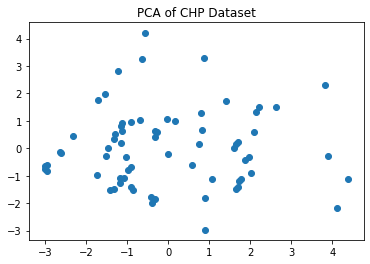

In [606]:
# Plotting
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.title('PCA of CHP Dataset')

In [607]:
cat = [col for col in surveyProc.columns.values] # x-val
loadings = pca.components_ # PCA loadings
loadingsPC1 = loadings[0,:] # PCA1
loadingsPC2 = loadings[1,:] # PCA2

Text(0.5, 1.0, 'Loadings for PCA 1')

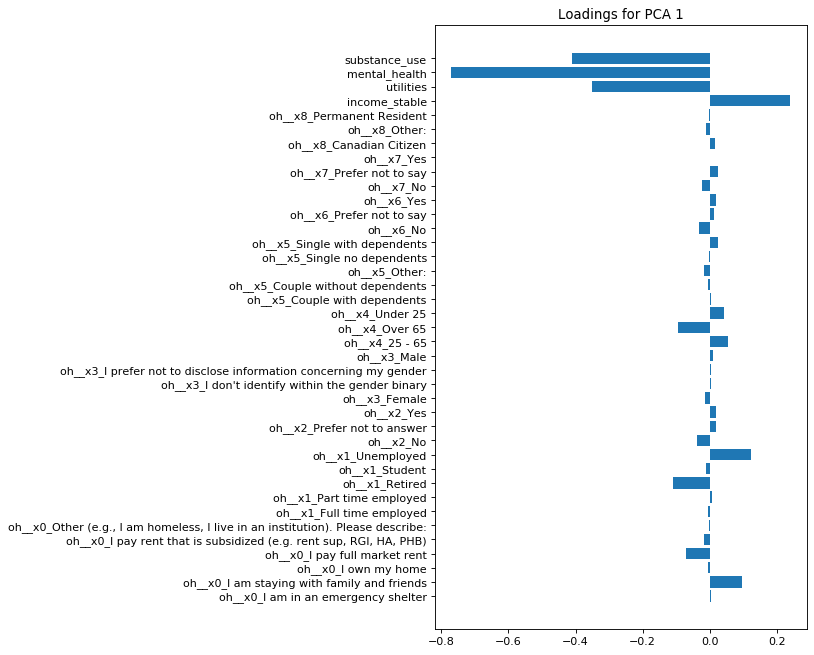

In [608]:
# Plotting
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC1)
plt.title('Loadings for PCA 1')

Text(0.5, 1.0, 'Loadings for PCA 2')

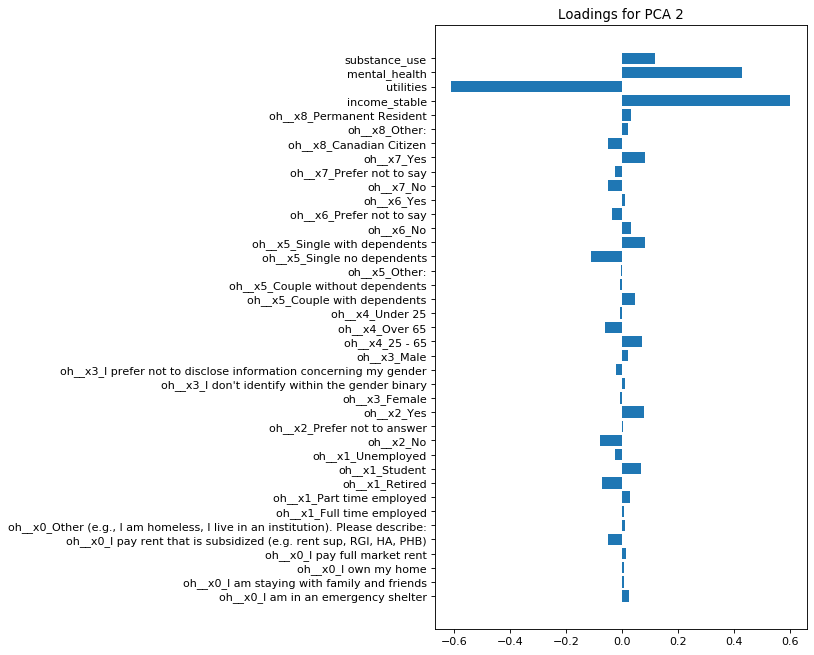

In [609]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(cat,loadingsPC2)
plt.title('Loadings for PCA 2')